## Scenario 1: Analysing a series of initial rate data using Michaelis-Menten kinetics 

Dataset provided by Maria F. Pinto (Institute of Biomedical Sciences, University of Porto, 4050-313 Porto, Portugal).

This Jupyter Notebook accompanies the fourth scenario of the paper: EnzymeML at work: seamless data flow and modelling of enzymatic data.
In this scenario, the time-course data from the EnzymeML document is formatted for the upload to the modelling webserver interferENZY. The webserver 
performs an estimation of the Michaelis-Menten kinetic parameters, which can be added to the existing EnzymeML document.

## Imports

Install and import all necessary Python packages.
In order to run on google Colaboratory (Colab), PyEnzyme will be installed and the dataset is loaded from GitHub. This is done in the first Code Cell.
To run the notebook on Colab click on the badge:
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/EnzymeML/Lauterbach_2021/blob/main/Scenario1/AnalysingInitialRateDataUsingMichaelisMentenKineticsinterferENZY.ipynb)  
If you run this notebook local make sure you have all Packages installed and the dataset in the same directory as the notebook.

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install git+git://github.com/EnzymeML/PyEnzyme.git@Refactoring
    !pip install lmfit
    !pip install regex
    !wget https://github.com/EnzymeML/Lauterbach_2021/raw/main/Scenario1/Desulfuration_Cysteine_Pinto.omex
    !wget https://github.com/EnzymeML/Lauterbach_2021/raw/main/Scenario1/Pinto_output_interferENZY.txt
else:
    print('Not running on Colab.')

Not running on Colab.


In [2]:
from pyenzyme import EnzymeMLDocument
from pyenzyme.enzymeml.models import MichaelisMentenVMax
from pyenzyme.enzymeml.core.ontology import DataTypes, SBOTerm

import numpy as np

import re
import matplotlib.pyplot as plt

## Function to visualise the time-course data of the dataset

The function is called later in the workflow, to include visualizations of the modelled data.

In [3]:
def vis_time_course(filename, reactant_ID):
    
    enzmldoc = EnzymeMLDocument.fromFile(filename)
    
    time_course_data = []

    # Get the concentration and time_units
    measurement = enzmldoc.getMeasurement('m0')
    time = measurement.global_time
    time_unit = measurement.global_time_unit
    conc_unit = ''

    # Get the replicates and the time_course data:
    for measurement in enzmldoc.measurement_dict.values():

        # get replicates with time course data:
        reactant = measurement.getReactant(reactant_ID)
        unitID = reactant._unit_id
        unitString = reactant.unit
        conc_unit = re.sub('mole / l', 'M', unitString)

        for replicate in reactant.replicates:
            # Include only concentration values
            if replicate.data_type == DataTypes.CONCENTRATION:
                time_course_data.append(replicate.data)

    time_course_data = np.array(time_course_data)
    time = np.array(time)

    # Plot the data using matplotlib
    reaction_name = enzmldoc.getReaction('r0').name
    plt.figure()
    ax = plt.subplot()
    for i in range(time_course_data.shape[0]):
        ax.plot(time, time_course_data[i, :], label='repl '+str(i+1))
    plt.title('interferENZY: '+reaction_name)
    ax.set_xlabel(f'time [{time_unit}]')
    ax.set_ylabel(f'concentration [{conc_unit}]')
    # Save the figure as a .svg file
    plt.savefig('time-course.svg', bbox_inches='tight')
    plt.show()

## Function to generate an input file for interferENZY

All necessary information, including the time-course data, initial substrate concentrations and enzyme concentration, are extracted from the dataset. The data is formatted according to the requirements set by interferENZY and exported as a .txt file. The file can then be uploaded to the webserver (https://interferenzy.i3s.up.pt) for the kinetic modelling.

In [4]:
# Write the input for the upload to interferENZY
def write_interferENZY(filename, reactant_id):
    path = filename
    enzmldoc = EnzymeMLDocument.fromFile(path)

    # Name of the dataset
    dataset_name = enzmldoc.name

    # Get the protein concentration
    for protein in enzmldoc.protein_dict.values():

        protein_conc = protein.init_conc
        protein_unit = protein.unit

    # Definitions of the reactants
    for reaction in enzmldoc.reaction_dict.values():

        # extract the educt to later define the initial concentrations
        educt_ID = reaction.educts[0].species_id
        reaction_products = reaction.products

    # Definte the variables    
    conc = ''
    time_course = ''
    data_s = []

    for measurement in enzmldoc.measurement_dict.values():

        reactants = measurement.getReactants()
        
        for reactantID, data in reactants.items():

            speciesID = data.reactant_id

            # Get the initial concentrations and write them into column form
            initConc = data.init_conc
            # include only the initial concentrations of the substrate
            if speciesID == educt_ID:
                conc += str(initConc) + '\t'

            # Export the replicates
            for replicate in data.replicates:

                if reactant_id == reactantID:
                    
                    # Inlcude only time-course data with concentration values
                    if replicate.data_type == DataTypes.CONCENTRATION:

                        # Get the concentration and time units
                        unit = replicate.data_unit
                        time_unit = replicate.time_unit

                        # Export time and concentration values
                        data_s.append(replicate.data)
                        data_time = replicate.time

    length = len(data_time)

    # Write the time-course data into column form
    # Include the time and concentration values alternately
    for i in range(length):
        for val in data_s:
            time_course += str(data_time[i]) + '\t' + str(val[i]) + '\t'
        time_course = time_course[:-2]
        time_course += '\n'

    # Formatting of the unit
    unit = re.sub('mole / l', 'M', unit)

    # Write the input data together and into a .txt file
    Input = f'{conc}\n{protein_conc}\n{time_unit}\n{unit}\n{dataset_name}\n{time_course}'

    # Write the input data together and into a .txt file
    new_file = re.sub('.omex', '_input_interferENZY.txt', filename)
    with open(new_file, 'w') as file:
        file.write(Input)

    print(Input)

## Example for the input generation

The function is called on the dataset of Maria Pinto ('Pinto.omex). In addition, it is specified that the concentration of the substrate L-cysteine ('s0') should be modelled. The formatted data is saved as an additional file for the upload ('Pinto_input_interferENZY.txt').

In [5]:
write_interferENZY('Desulfuration_Cysteine_Pinto.omex', 's1')

500.0	100.0	50.0	25.0	10.0	5.0	
1.0
min
uM
Pinto_Measurements (modelled by interferENZY)
0.0	0.661580302	0.0	0.436642999	0.0	0.704583021	0.0	0.24147681	0.0	0.231553106	0.0	0.1984740
1.0	2.404844396	1.0	2.378381184	1.0	2.103825359	1.0	1.538174201	1.0	1.157765528	1.0	0.87328599
2.5	5.765672328	2.5	4.647601619	2.5	4.763378172	2.5	3.44352547	2.5	3.383983243	2.5	1.6671823



## Function to include the modelled parameters in the document

The results file generated by interferENZY is read in and the values for Km and vmax are extracted. After reformating, the parameters and the equation for the Michaelis-Menten model are added to the existing EnzymeML document.

In [6]:
# Read the output file from interferENZY and visualize the time-course data
def add_kinetic_model(filename, output, reactant_id):

    enzmldoc = EnzymeMLDocument.fromFile(filename)
    
    reaction_id = 'r0'

    # Fetch the measurement
    measurement0 = enzmldoc.getMeasurement('m0')
    reactants = measurement0.getReactants()

    for reactantID, data in reactants.items():
        
        # get only the chosen reactant
        if reactantID == reactant_id:

            for replicate in data.replicates:

                # Get the units of the time-course data
                time_unit = replicate.time_unit
                rct_unit = replicate.data_unit
                break
                
    # Load the output file generated by interferENZY
    with open(output, 'r') as file:
        filetext = file.read()

    # Find the calculated parameters and extract Km and vmax
    parameter = re.findall("Best guess for apparent kinetic parameters from final score analysis:.\nInstant 	 Km 	 SE 	 V 	 SE \n1	\d+.\d+	\d+.\d+	\d+.\d+	\d+.\d+?", filetext)
    parameter = re.sub("Best guess for apparent kinetic parameters from final score analysis:.\nInstant 	 Km 	 SE 	 V 	 SE \n1	", "", parameter[0])
    parameter = re.split('\t', parameter)
    
    Km_val = parameter[0]
    vmax_val = parameter[2]
    
    # Truncate the parameter at 3 decimal points
    Km_val = re.sub(r'^(\d+\.\d{,3})\d*$',r'\1',Km_val)
    vmax_val = re.sub(r'^(\d+\.\d{,3})\d*$',r'\1',vmax_val)
    
    # Change unit
    rct_unit = re.sub('mole / l', 'M', rct_unit)
    
    # Generate the model using the parameters given
    model = MichaelisMentenVMax(
        substrate=reactant_id,
        vmax={"value": vmax_val, "unit": f"{rct_unit}/{time_unit}"},
        k_m={"value": Km_val, "unit": rct_unit},
        enzmldoc=enzmldoc
    )
    
    print('Modelled were the following time-courses:')
    vis_time_course(filename, reactant_id)
    
    text_kinetic_model = f'Michaelis-Menten model: {model.equation}\nKm = {Km_val} {rct_unit}\nvmax = {vmax_val} {rct_unit}/{time_unit}'
    print(text_kinetic_model)
    
    enzmldoc.getReaction(reaction_id).setModel(model, enzmldoc)
    
    out_dir = "Modelled"
    enzmldoc.toFile(out_dir, name=enzmldoc.name + "_Modelled")
    
    return enzmldoc


## Example for the parameter read-in

The parameters generated by interferENZY ('Pinto_output_interferENZY.txt') are included and the result is printed out. In addition, the time-course of the modelled reactant is visualised.

Modelled were the following time-courses:


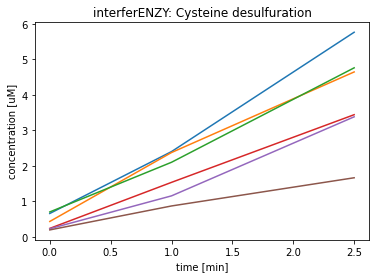

Michaelis-Menten model: vmax * 's1' / (k_m + 's1')
Km = 6.900 uM
vmax = 1.814 uM/min

Archive was written to Modelled/Pinto_Measurements_(modelled_by_interferENZY)_Modelled.omex



In [7]:
enzmldoc = add_kinetic_model('Desulfuration_Cysteine_Pinto.omex', 'Pinto_output_interferENZY.txt', 's1')

## Upload to DaRUS <a class="anchor" name="Upload"></a>
Finally, the EnzymeML document is published on DaRUS.   
In order to publish a dataset to DaRUS you need an API Token.  
If you want to publish set the `publish` variable to `True`. Then you will be asked for your API Token.

In [8]:
publish = True

if publish:
    enzmldoc.uploadToDataverse("playground")


Archive was written to ./Pinto_Measurements_(modelled_by_interferENZY)_dv_upload.omex

Dataset with pid 'doi:10.18419/darus-2487' created.
